In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tskit
import tsinfer

print(f"tskit {tskit.__version__}")
print(f"tsinfer {tsinfer.__version__}")

tskit 0.5.3
tsinfer 0.2.4.dev63+gd36be42


### Load data

In [2]:
base_dir = Path("/home/shing_zhan/analysis/pass_4/")
ts_file = base_dir / "from_42_into_3.imputed.trees"

In [3]:
ts = tskit.load(ts_file)
ts

### Examine the correlation between edge span and edge time

In [4]:
edge_spans = ts.edges_right - ts.edges_left
edge_parent_times = ts.nodes_time[ts.edges_parent]
edge_child_times = ts.nodes_time[ts.edges_child]

if edge_spans[-1] == ts.sequence_length:
    edge_spans = edge_spans[:-2]
    edge_parent_times = edge_parent_times[:-2]
    edge_child_times = edge_child_times[:-2]

edge_spans = edge_spans / 1e6

df_edges = pd.DataFrame({
    'edge_spans': edge_spans,
    'edge_parent_times': edge_parent_times,
    'edge_child_times': edge_child_times,
})

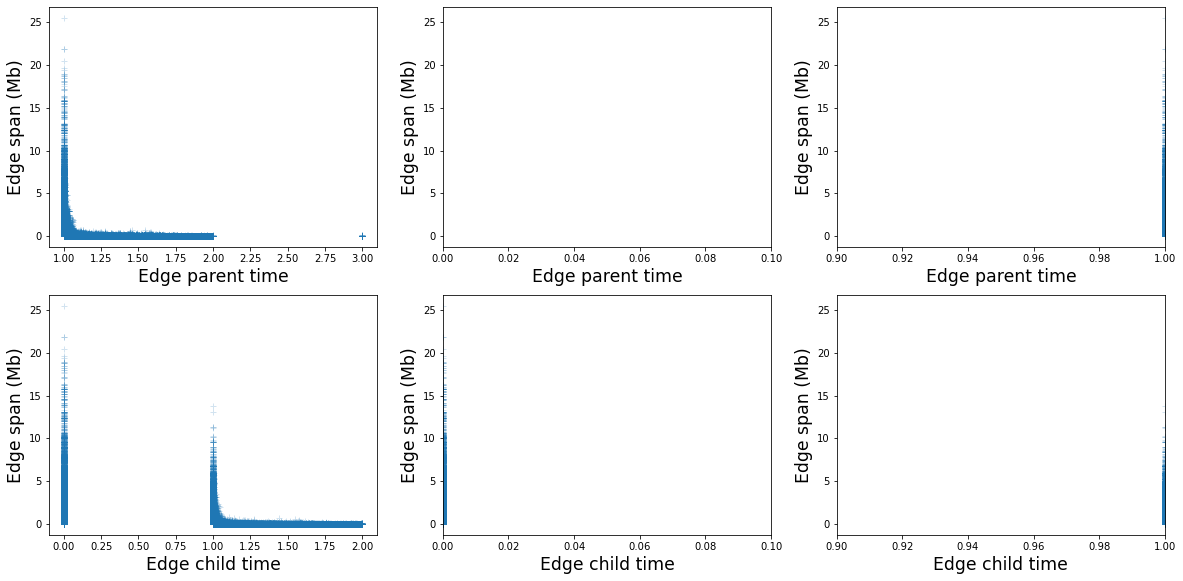

In [5]:
plt.figure(figsize=(20, 15,))

plt.subplot(331)
plt.xlabel("Edge parent time", fontsize="xx-large")
plt.ylabel("Edge span (Mb)", fontsize="xx-large")
plt.plot(
    df_edges["edge_parent_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.subplot(332)
plt.xlabel("Edge parent time", fontsize="xx-large")
plt.ylabel("Edge span (Mb)", fontsize="xx-large")
plt.xlim(0.0, 0.1)
plt.plot(
    df_edges["edge_parent_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.subplot(333)
plt.xlabel("Edge parent time", fontsize="xx-large")
plt.ylabel("Edge span (Mb)", fontsize="xx-large")
plt.xlim(0.9, 1.0)
plt.plot(
    df_edges["edge_parent_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.subplot(334)
plt.xlabel("Edge child time", fontsize="xx-large")
plt.ylabel("Edge span (Mb)", fontsize="xx-large")
plt.plot(
    df_edges["edge_child_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.subplot(335)
plt.xlabel("Edge child time", fontsize="xx-large")
plt.ylabel("Edge span (Mb)", fontsize="xx-large")
plt.xlim(0.0, 0.1)
plt.plot(
    df_edges["edge_child_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.subplot(336)
plt.xlabel("Edge child time", fontsize="xx-large")
plt.ylabel("Edge span (Mb)", fontsize="xx-large")
plt.xlim(0.9, 1.0)
plt.plot(
    df_edges["edge_child_times"],
    df_edges["edge_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.show()

### Examine the correlation between node span and node time

In [6]:
node_spans = tsinfer.node_span(ts)
node_times = ts.nodes_time

if node_spans[-1] == ts.sequence_length:
    node_spans = node_spans[:-2]
    node_times = node_times[:-2]

node_spans = node_spans / 1e6

df_nodes = pd.DataFrame({
    'node_spans': node_spans,
    'node_times': node_times,
})

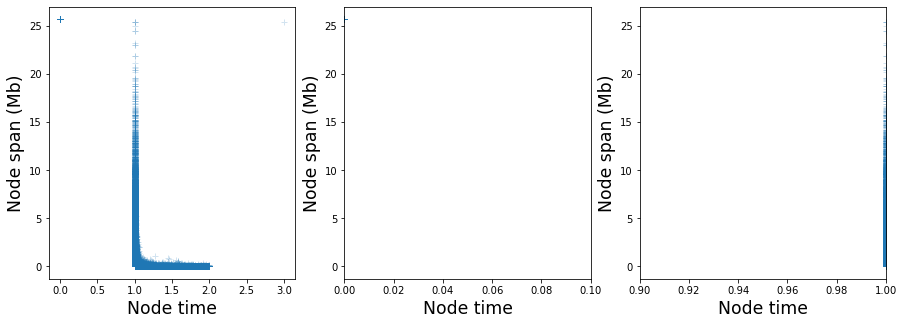

In [7]:
plt.figure(figsize=(15, 5,))

plt.subplot(131)
plt.xlabel("Node time", fontsize="xx-large")
plt.ylabel("Node span (Mb)", fontsize="xx-large")
plt.plot(
    df_nodes["node_times"],
    df_nodes["node_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.subplot(132)
plt.xlabel("Node time", fontsize="xx-large")
plt.ylabel("Node span (Mb)", fontsize="xx-large")
plt.xlim(0.0, 0.1)
plt.plot(
    df_nodes["node_times"],
    df_nodes["node_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.subplot(133)
plt.xlabel("Node time", fontsize="xx-large")
plt.ylabel("Node span (Mb)", fontsize="xx-large")
plt.xlim(0.9, 1.0)
plt.plot(
    df_nodes["node_times"],
    df_nodes["node_spans"],
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

### Distribution of mutations per site

In [8]:
site_pos, counts = np.unique(ts.mutations_site, return_counts=True)
num_sites_with_mutation = len(site_pos)
print(f"Sites total: {ts.num_sites}")
print(f"Sites with at least one mutation: {num_sites_with_mutation}")

Sites total: 136087
Sites with at least one mutation: 114352


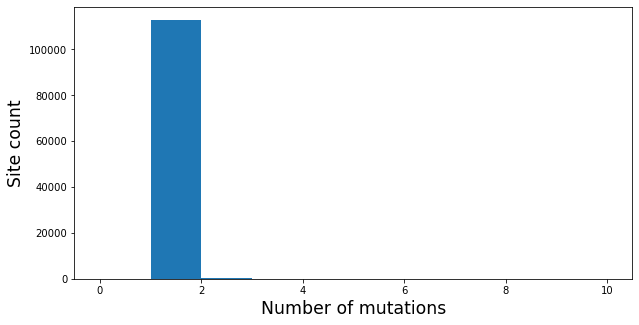

In [9]:
plt.figure(figsize=(10, 5,))
plt.ylabel("Site count", fontsize="xx-large")
plt.xlabel("Number of mutations", fontsize="xx-large")
plt.hist(counts, bins=range(11));
plt.show()

### Distribution of arity

In [10]:
# Unsimplified, a tree sequence contains unary nodes,
# so exclude them before calculating arity.
ts_simplified = ts.simplify()

# For each tree, take the mean arity across its nodes.
tree_arity = np.empty(ts_simplified.num_trees)
for i, tree in enumerate(ts_simplified.trees()):
    parent_id, count = np.unique(tree.parent_array[tree.preorder()], return_counts=True)
    tree_arity[i] = count[parent_id != tskit.NULL].mean()

# For each node, take the mean arity across trees.
node_arity = np.zeros(ts_simplified.num_nodes)
for tree in ts_simplified.trees():
    node_arity += tree.num_children_array[:-1] * tree.span
node_arity /= ts_simplified.sequence_length

/tmp/ipykernel_17971/2322094717.py:9: RuntimeWarning: Mean of empty slice.
  tree_arity[i] = count[parent_id != tskit.NULL].mean()
/home/shing_zhan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


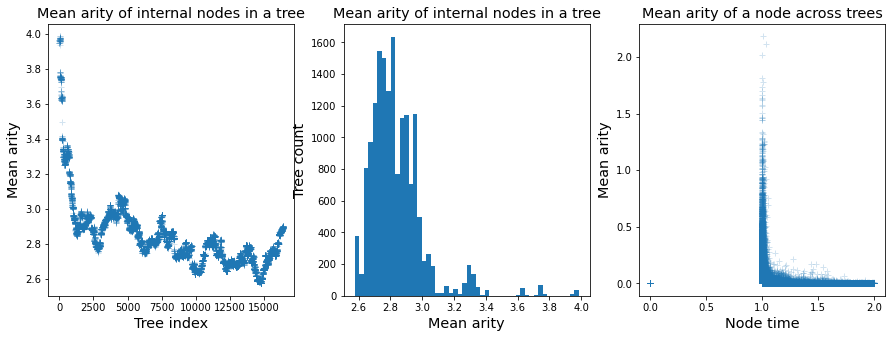

In [11]:
plt.figure(figsize=(15, 5,))

plt.subplot(131)
plt.title("Mean arity of internal nodes in a tree", fontsize="x-large")
plt.ylabel("Mean arity", fontsize="x-large")
plt.xlabel("Tree index", fontsize="x-large")
plt.plot(
    np.arange(ts_simplified.num_trees),
    tree_arity,
    linestyle="none", marker="+", markersize=6, alpha=0.2,
);

plt.subplot(132)
plt.title("Mean arity of internal nodes in a tree", fontsize="x-large")
plt.ylabel("Tree count", fontsize="x-large")
plt.xlabel("Mean arity", fontsize="x-large")
plt.hist(tree_arity, bins=50);

plt.subplot(133)
plt.title("Mean arity of a node across trees", fontsize="x-large")
plt.ylabel("Mean arity", fontsize="x-large")
plt.xlabel("Node time", fontsize="x-large")
plt.plot(
    ts_simplified.nodes_time,
    node_arity,
    linestyle='none', marker='+', markersize=6, alpha=0.2,
);

plt.show()

### Distribution of edge diffs

In [12]:
tree_edges_out = np.empty(ts.num_trees)
tree_edges_in = np.empty(ts.num_trees)
for i, (interval, edges_out, edges_in,) in enumerate(ts.edge_diffs()):
    tree_edges_out[i] = len(edges_out)
    tree_edges_in[i] = len(edges_in)

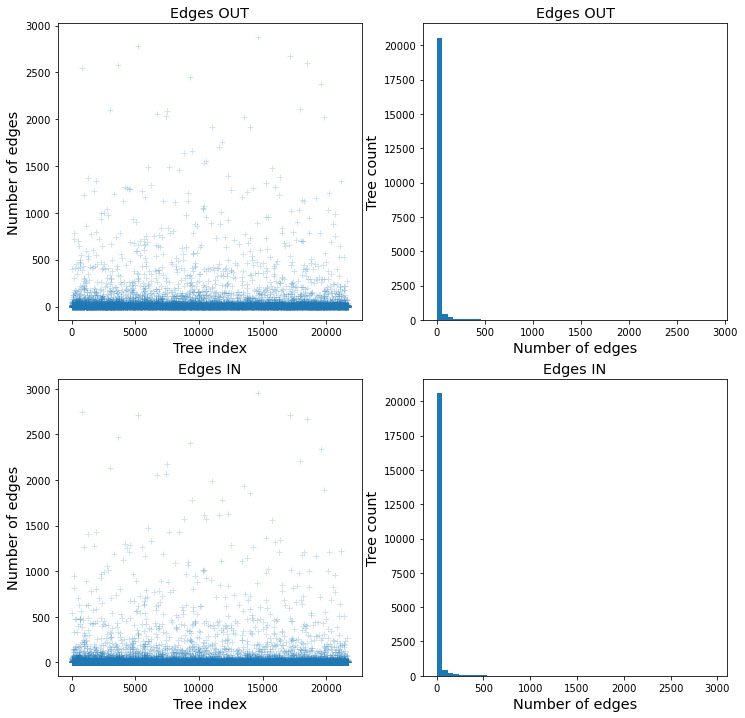

In [13]:
# Exclude the first, second, penultimate, and last sets of edge diffs.
plt.figure(figsize=(12, 12,))

plt.subplot(221)
plt.title("Edges OUT", fontsize="x-large")
plt.ylabel("Number of edges", fontsize="x-large")
plt.xlabel("Tree index", fontsize="x-large")
plt.plot(
    np.arange(2, ts.num_trees - 2),
    tree_edges_out[2:-2],
    linestyle="none", marker="+", markersize=6, alpha=0.2,
);

plt.subplot(222)
plt.title("Edges OUT", fontsize="x-large")
plt.ylabel("Tree count", fontsize="x-large")
plt.xlabel("Number of edges", fontsize="x-large")
plt.hist(tree_edges_out[2:-2], bins=50);

plt.subplot(223)
plt.title("Edges IN", fontsize="x-large")
plt.ylabel("Number of edges", fontsize="x-large")
plt.xlabel("Tree index", fontsize="x-large")
plt.plot(
    np.arange(2, ts.num_trees - 2),
    tree_edges_in[2:-2],
    linestyle="none", marker="+", markersize=6, alpha=0.2,
);

plt.subplot(224)
plt.title("Edges IN", fontsize="x-large")
plt.ylabel("Tree count", fontsize="x-large")
plt.xlabel("Number of edges", fontsize="x-large")
plt.hist(tree_edges_in[2:-2], bins=50);

plt.show()

### Examine the edges copying into the samples

In [14]:
per_sample_num_edges = np.empty(ts.num_samples)
per_sample_bkpt_density = np.empty(ts.num_samples)
per_sample_mean_parent_time = np.empty(ts.num_samples)

# TODO: Is there a faster way than appending to a Python list?
left_coords_all = []
parent_times_all = []

all_edges = ts.tables.edges
for i in ts.samples():
    assert ts.nodes_time[i] == 0
    # Subset edges table
    tmp_tb = all_edges[ts.tables.edges.child == i]
    # Get number of edges copying into a sample
    tmp_num_edges = tmp_tb.child.shape[0]
    per_sample_num_edges[i] = tmp_num_edges
    # Get the left coordinates of these edges
    tmp_left_coords = tmp_tb.left
    left_coords_all += list(tmp_left_coords)
    # Get the parent times of these edges
    tmp_parent_times = ts.nodes_time[tmp_tb.parent]
    parent_times_all += list(tmp_parent_times)
    assert tmp_left_coords.shape[0] == tmp_parent_times.shape[0]
    # Get the per-sample breakpoint density (per 1 Mb)
    per_sample_bkpt_density[i] = tmp_left_coords.shape[0] / (ts.sequence_length / 1e6)
    # Get the per-sample mean parent time
    per_sample_mean_parent_time[i] = np.mean(tmp_parent_times)

left_coords_all = np.array(left_coords_all)
parent_times_all = np.array(parent_times_all)

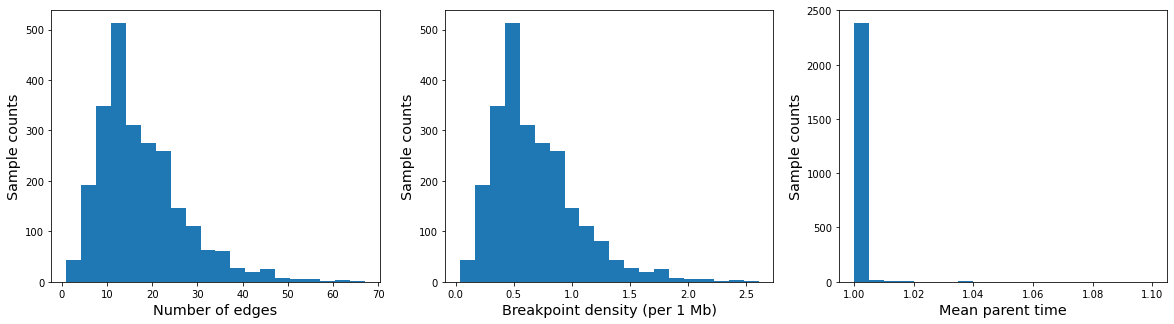

In [15]:
plt.figure(figsize=(20, 5,))

plt.subplot(131)
plt.ylabel("Sample counts", fontsize="x-large")
plt.xlabel("Number of edges", fontsize="x-large")
plt.hist(per_sample_num_edges, bins=20);

plt.subplot(132)
plt.ylabel("Sample counts", fontsize="x-large")
plt.xlabel("Breakpoint density (per 1 Mb)", fontsize="x-large")
plt.hist(per_sample_bkpt_density, bins=20);

plt.subplot(133)
plt.ylabel("Sample counts", fontsize="x-large")
plt.xlabel("Mean parent time", fontsize="x-large")
plt.hist(per_sample_mean_parent_time, bins=20);

plt.show()

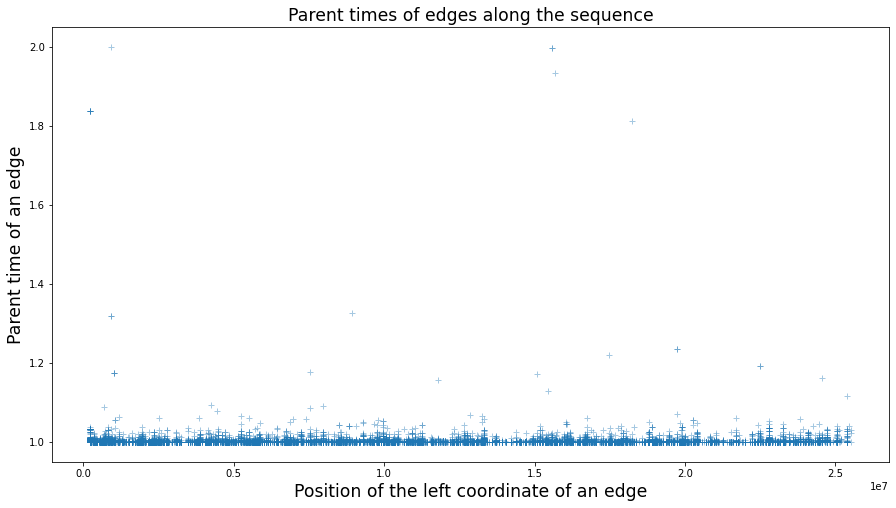

In [16]:
plt.figure(figsize=(15, 8,))
plt.title("Parent times of edges along the sequence", fontsize="xx-large")
plt.ylabel("Parent time of an edge", fontsize="xx-large")
plt.xlabel("Position of the left coordinate of an edge", fontsize="xx-large")
plt.plot(
    left_coords_all,
    parent_times_all,
    linestyle="none", marker="+", markersize=6, alpha=0.4,
);
plt.show()

In [17]:
num_bins = int(np.ceil(ts.sequence_length / 1e6))
bkpt_binned_counts = np.zeros(num_bins)
for i in np.arange(num_bins):
    is_left = i * 1e6 <= left_coords_all
    is_right = left_coords_all < (i + 1) * 1e6
    bkpt_binned_counts[i] = np.sum(is_left & is_right) / 1e6    # No need to normalize

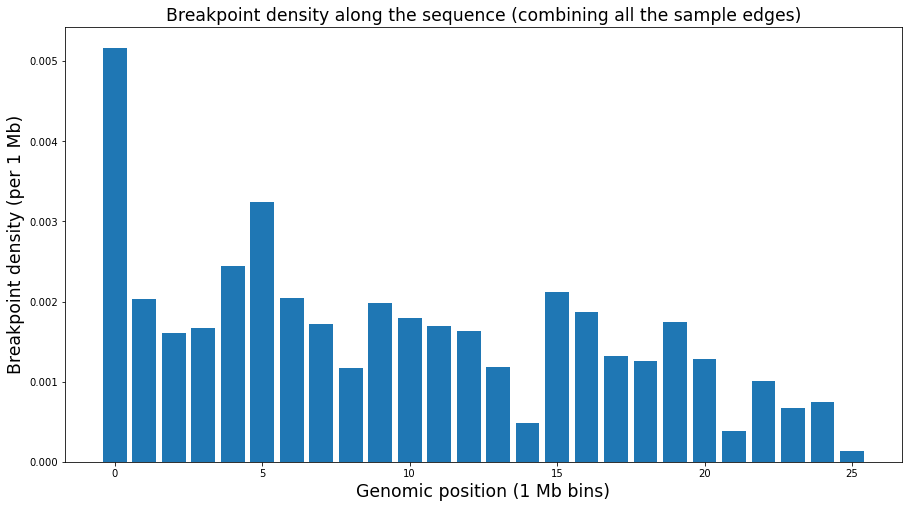

In [18]:
plt.figure(figsize=(15, 8,))
plt.title("Breakpoint density along the sequence (combining all the sample edges)", fontsize="xx-large")
plt.ylabel("Breakpoint density (per 1 Mb)", fontsize="xx-large")
plt.xlabel("Genomic position (1 Mb bins)", fontsize="xx-large")
plt.bar(
    np.arange(num_bins),
    bkpt_binned_counts,
);
plt.show()